/home/bob/.local/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/home/bob/.local/lib/python3.8/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/home/bob/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(240, 256, 3),
 0.0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}
Using CUDA: True

Episode 0 - Step 303 - Epsilon 0.09992427858844306 - Mean Reward 1891.0 - Mean Length 303.0 - Mean Loss 1.655 - Mean Q Value 59.766 - Time Delta 3.142 - Time 2024-05-19T11:46:57
MarioNet saved to checkpoints_save/2024-05-19T11-46-57/mario_net_0.chkpt at step 303
MarioNet saved to chkpoint.chkpt
Episode 20 - Step 3496 - Epsilon 0.0991298071940275 - Mean Reward 851.238 - Mean Length 166.476 - Mean Loss 1.058 - Mean Q Value 50.123 - Time Delta 39.45 - Time 2024-05-19T11:47:36
Episode 40 - Step 6555 - Epsilon 0.098374602444195 - Mean Reward 784.439 - Mean Length 159.878 - Mean Loss 0.979 - Mean Q Value 48.047 - Time Delta 36.983 - Time 2024-05-19T11:48:13
Episode 60 - Step 11368 - Epsilon 0.0971980014906334 - Mean Reward 874.361 - Mean Length 186.361 - Mean Loss 1.074 - Mean Q Value 46.869 - Time Delta 57.51

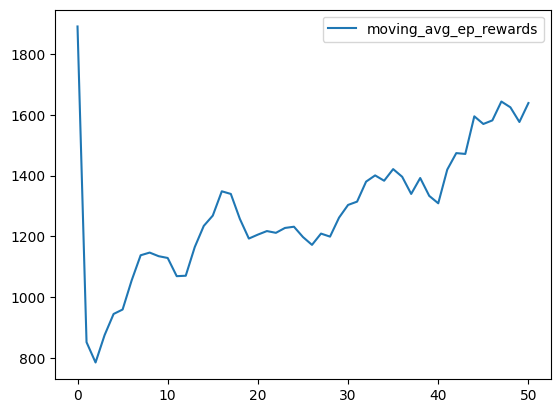

In [11]:
from mad_mario import *

class MyMario(Mario):
    def __init__(self, state_dim, action_dim, save_dir):
        super().__init__(state_dim, action_dim, save_dir)
        self.exploration_rate_decay = 1 - ((1 - 0.99999975 ) * 10)
        self.exploration_rate_min = 0
        self.default_chkpoint = "chkpoint.chkpt"
        self.burnin = 200
        
        self.learn_from_death_count = 10



env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb_array', apply_api_compatibility=True)
# Limit the action-space to
#   0. walk right
#   1. jump right
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")



# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

mario = MyMario(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

# Load from default chkpt.
if Path(mario.default_chkpoint).is_file():
    dic = torch.load(mario.default_chkpoint)
    mario.net.load_state_dict(dic["model"])
    mario.exploration_rate = dic["exploration_rate"]

logger = MetricLogger(save_dir)

episodes = 1000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        if done == True:
            for idx in range(mario.learn_from_death_count):
                mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()
        
        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)    

    if (e % 200 == 0) or (e == episodes - 1):
        # Save to timestamped dir
        save_dir = Path("checkpoints_save") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
        save_dir.mkdir(parents=True)
        mario.save_dir = save_dir
        mario.save()

        # Save to default dir
        torch.save(
            dict(model=mario.net.state_dict(), exploration_rate=mario.exploration_rate),
            mario.default_chkpoint,
        )
        print(f"MarioNet saved to {mario.default_chkpoint}")


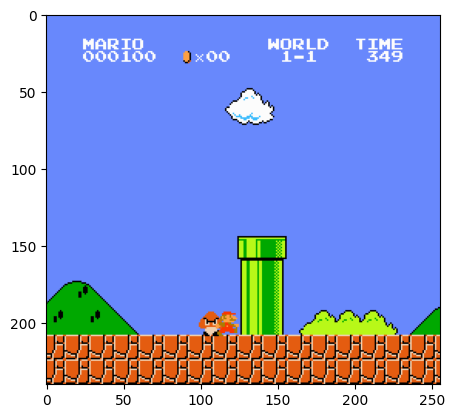

Episode 1 - Step 1452600 - Epsilon 0 - Mean Reward 1369.5 - Mean Length 1132.0 - Mean Loss 1.538 - Mean Q Value 48.449 - Time Delta 33.294 - Time 2024-05-19T11:46:53


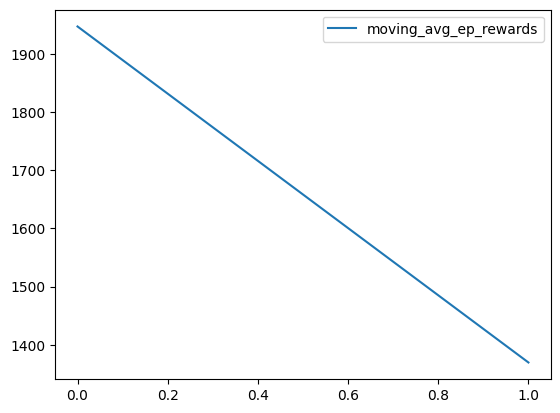

In [10]:
from IPython.display import clear_output
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
logger = MetricLogger(save_dir)

mario.exploration_rate_min = 0
mario.exploration_rate = 0

episodes = 2
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:
        clear_output(wait=True)
        plt.imshow( env.render() )
        plt.show()
        
        # Run agent on the state
        action = mario.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        mario.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = mario.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done or info["flag_get"]:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=mario.exploration_rate, step=mario.curr_step)